In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import jinja2
import json
import re
import os

In [2]:
# {se, aje, aerj, asr, ajs, bjse, isse}.json
path = "../data/eric/se.json"

In [3]:
with open(path, "r") as infile:
    # se, aje, aerj, asr, ajs, bjse, isse - records queried using the ERIC API https://eric.ed.gov/?api
    d = json.load(infile)
records = d["response"]["docs"]
print(f"Number of files: {len(records)}")

Number of files: 1035


## Average xml length in tokens:

In [4]:
# go one dir up
llama_dir = os.path.join(os.getcwd(), "..", "..", "codellama", "CodeLlama-7b-Instruct-hf")
tokenizer = AutoTokenizer.from_pretrained(llama_dir, local_files_only=True)

In [5]:
print(str(records[0]))

{'id': 'EJ1158833', 'title': 'Gender Differences in Context: The Impact of Track Position on Study Involvement in Flemish Secondary Education', 'author': ['Van Houtte, Mieke'], 'description': "This study examines whether the influence of track position on study involvement is gendered and whether gender differences in study involvement according to track position are associated with school misconduct and rather poor future perspectives. Three-level analyses (HLM 6) of data gathered in 2004-2005 from 11,872 third- and fifth-grade students in 146 tracks in a representative sample of 85 secondary schools in Flanders (Belgium) confirmed the impact of tracking on boys' as well as girls' study involvement. Boys are, generally, less involved in studying than girls, and boys are more affected by track position than girls are, enlarging the gender gap in the lower tracks. In these tracks, boys are more prone to misconduct and rather poor future perspectives. Finally, girls in arts tracks are, o

Mean: 349.23961352657005 | Std: 162.67792956923432 | Max: 913 | Min: 88


(array([ 41., 332., 315.,  14.,  44., 149., 114.,  24.,   0.,   2.]),
 array([ 88. , 170.5, 253. , 335.5, 418. , 500.5, 583. , 665.5, 748. ,
        830.5, 913. ]),
 <BarContainer object of 10 artists>)

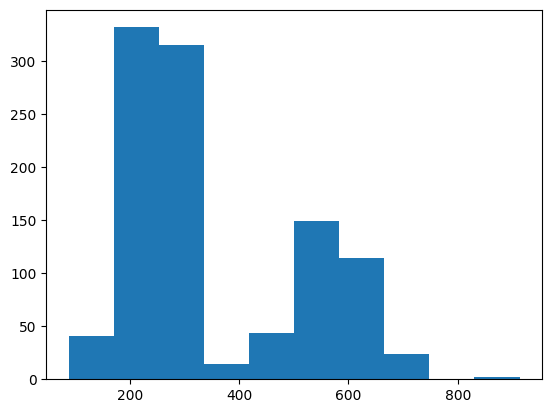

In [6]:
rec_lens = []
for rec in records:
    rec_lens.append(len(tokenizer.tokenize(str(rec))))
print(f"Mean: {np.mean(rec_lens)} | Std: {np.std(rec_lens)} | Max: {np.max(rec_lens)} | Min: {np.min(rec_lens)}")
plt.hist(rec_lens)

LLaMA2-Code has a functional context length of 16k tokens.

## Prompt Engineering

In [7]:
class jinjitsu():
    def __init__(self, template_dir, template_file, exampleVars):
        self.templateLoader = jinja2.FileSystemLoader(searchpath=template_dir)
        self.templateEnv = jinja2.Environment( loader=self.templateLoader )
        self.template = self.templateEnv.get_template( template_file )
        self.example = self.template.render( exampleVars )

    def render(self, templateVars):
        return self.template.render( templateVars )

In [8]:
with open("../prompts/examples/json_example.json", "r") as infile:
        exampleVars = json.load(infile)

In [9]:
jinjaLoader = jinjitsu("../prompts", "json.jinja", exampleVars)

### Average one-shot prompt length in tokens for each journal (w/o RAG):

In [10]:
journals = ["se", "aje", "aerj", "asr", "ajs", "bjse", "isse"]

In [11]:
for journal in journals:
    prompt_lens = []
    path = f"../data/eric/{journal}.json"
    with open(path, "r") as infile:
        d = json.load(infile)
    records = d["response"]["docs"]
    for rec in records:
        templateVars = {"input": str(rec), "output": ""}
    PROMPT = "\n".join([jinjaLoader.example, jinjaLoader.render(templateVars)])
    prompt_lens.append(len(tokenizer.tokenize(PROMPT)))
    print(f"Journal: {journal.upper()}, {len(records)} records")
    print(f"Mean: {np.mean(prompt_lens)} | Std: {np.std(prompt_lens)} | Max: {np.max(prompt_lens)} | Min: {np.min(prompt_lens)}", "\n")

Journal: SE, 1035 records
Mean: 2041.0 | Std: 0.0 | Max: 2041 | Min: 2041 

Journal: AJE, 789 records
Mean: 2017.0 | Std: 0.0 | Max: 2017 | Min: 2017 

Journal: AERJ, 1912 records
Mean: 1794.0 | Std: 0.0 | Max: 1794 | Min: 1794 

Journal: ASR, 350 records
Mean: 1515.0 | Std: 0.0 | Max: 1515 | Min: 1515 

Journal: AJS, 333 records
Mean: 1535.0 | Std: 0.0 | Max: 1535 | Min: 1535 

Journal: BJSE, 1223 records
Mean: 1931.0 | Std: 0.0 | Max: 1931 | Min: 1931 

Journal: ISSE, 386 records
Mean: 1824.0 | Std: 0.0 | Max: 1824 | Min: 1824 



### Correct JSON response length in tokens:

In [12]:
all_false = json.dumps({"quantitative": False, "qualitative": False, "primary/secondary": False, "tertiary": False, "inequality": False, "nonstructural": False, "culture": False, "school": False, "state": False, "labor": False, "comparative": False, "methods": False})
print(f"Length of max expected JSON output in tokens: {len(tokenizer.tokenize(all_false))}")

Length of max expected JSON output in tokens: 74
